# WEEK 2: Deep Learning Fundamentals with Fashion MNIST

---

## LEARNING OBJECTIVES
By the end of this exercise, you will be able to:
1. Load and preprocess image data using PyTorch's DataLoader
2. Design a feedforward neural network architecture
3. Implement a complete training loop with forward/backward propagation
4. Apply regularization techniques (L1, L2, Dropout) to prevent overfitting
5. Use Early Stopping to optimize training duration
6. Perform hyperparameter tuning using Grid Search and Random Search

## DATASET: Fashion MNIST
- 70,000 grayscale images (28×28 pixels) of 10 clothing categories
- Categories: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
- Training set: 60,000 images | Test set: 10,000 images

## INSTRUCTIONS
- Look for `# TODO:` comments - these are YOUR tasks to complete
- Each TODO has a **HINT** and **EXPECTED OUTPUT** to guide you
- Use the verification cells to check your work before moving on
- Ask questions if you're stuck

---
## Section 1: Imports & Setup


In [ ]:
import torch                              # Core tensor operations (like NumPy but with GPU support)
import torch.nn as nn                     # Neural network building blocks (layers, activations)
import torch.optim as optim               # Optimization algorithms (SGD, Adam, etc.)
import torchvision                        # Computer vision datasets and transforms
import torchvision.transforms as transforms  # Image preprocessing utilities
from torch.utils.data import DataLoader, random_split  # Data loading utilities
import numpy as np                        # Numerical computing
import matplotlib.pyplot as plt           # Visualization
%matplotlib inline
from sklearn.metrics import accuracy_score  # Model evaluation metrics
import random                             # Random number generation
from itertools import product             # Can use for grid search combinations

# Set random seeds for reproducibility (important for debugging!)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print(" All imports successful!")
print(f" PyTorch version: {torch.__version__}")
print(f" CUDA available: {torch.cuda.is_available()}")

 All imports successful!
 PyTorch version: 2.9.0+cu126
 CUDA available: True


---
## Section 2: Data Loading & Preprocessing

### CONCEPT: Data Transforms
Before feeding images to a neural network, we must convert them to tensors.

`transforms.ToTensor()` does two things:
1. Converts PIL Image to Tensor
2. Scales pixel values from [0, 255] to [0.0, 1.0]

 **Resources:**
- [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)
- [Normalize](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)

In [ ]:
transform = transforms.ToTensor()

### TODO 1: Load the Fashion MNIST datasets

**HINT:** Use `torchvision.datasets.FashionMNIST()`
- Required parameters: `root='./data'`, `train=True/False`, `download=True`, `transform=transform`

**EXPECTED:**
- `train_dataset` should have 60,000 samples
- `test_dataset` should have 10,000 samples

In [ ]:
# TODO 1: Load Fashion MNIST datasets

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.67MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.9MB/s]


In [ ]:
# VERIFICATION - Run this cell after completing TODO 1
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


### TODO 2: Split the training data into training and validation sets

**WHY?** Validation data helps us monitor for overfitting during training. We never train on validation data - it's our "practice test."


In [ ]:
# TODO 2: Split training data into train and validation sets

train_size = 50000
val_size = 10000

# Uncomment after filling above:
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
# VERIFICATION - Run this cell after completing TODO 2
print(f"Training split: {len(train_dataset)} samples")
print(f"Validation split: {len(val_dataset)} samples")

Training split: 50000 samples
Validation split: 10000 samples


### TODO 3: Create DataLoaders for efficient batching

**WHY DataLoaders?**
- **Automatic batching:** Groups samples into mini-batches for training
- **Shuffling:** Randomizes order each epoch to prevent learning data order

**HINT:** `DataLoader(dataset, batch_size=64, shuffle=True/False)`
- Training: `shuffle=True` (prevents memorizing order)
- Validation/Test: `shuffle=False` (consistent evaluation)

**Resource:** [DataLoader Documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [ ]:

# TODO 3: Create DataLoaders

BATCH_SIZE = 64  # Number of samples per gradient update

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# VERIFICATION - Run this cell after completing TODO 3
sample_batch, sample_labels = next(iter(train_loader))
print(f"Batch shape: {sample_batch.shape} (expected: [64, 1, 28, 28])")
print(f"Labels shape: {sample_labels.shape} (expected: [64])")

Batch shape: torch.Size([64, 1, 28, 28]) (expected: [64, 1, 28, 28])
Labels shape: torch.Size([64]) (expected: [64])


---
## Section 3: Neural Network Architecture

### CONCEPT: Feedforward Neural Network (Multi-Layer Perceptron)

**Architecture (optional architecture):**
```
Input (784) → Hidden1 (256) → Hidden2 (128) → Output (10)
```

- **Input:** 28×28 = 784 pixels (flattened image)
- **Hidden layers:** Learn increasingly abstract features
- **Output:** 10 neurons (one per clothing category)

**Key Components:**
- `nn.Linear(in, out)`: Fully connected layer (y = Wx + b)
- `nn.ReLU()`: Activation function (introduces non-linearity)
- `nn.Dropout(p)`: Randomly zeros p% of neurons (prevents overfitting)

**Resources:**
- [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [ ]:
class FashionMNIST_NN(nn.Module):
    """
    A simple feedforward neural network for Fashion MNIST classification.

    Architecture:
        Input (784) → FC1 (256) → ReLU → Dropout → FC2 (128) → ReLU → Dropout → FC3 (10) (optional, you can try different architectures)

    Args:
        dropout_rate (float): Probability of dropping neurons (0.0 to 1.0)
    """

    def __init__(self, dropout_rate=0.5):
        super(FashionMNIST_NN, self).__init__()

        # ---------------------------------------------------------------------
        # TODO 4: Define the network layers
        # ---------------------------------------------------------------------
        # HINT: Create three linear layers and dropout

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        Forward pass: Defines how data flows through the network.

        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            Output tensor of shape (batch_size, 10) - raw scores (logits)
        """
        # ---------------------------------------------------------------------
        # TODO 5: Implement the forward pass
        # ---------------------------------------------------------------------
        # STEP 1: Flatten the input from (batch, 1, 28, 28) to (batch, 784)
        #         HINT: x = x.view(x.size(0), -1)  OR  x = x.flatten(start_dim=1)
        #
        # STEP 2: Pass through layers in order:
        #         fc1 → relu → dropout → fc2 → relu → dropout → fc3
        #
        # IMPORTANT: Do NOT apply softmax here! CrossEntropyLoss expects raw logits.
        #
        # EXPECTED OUTPUT SHAPE: (batch_size, 10)
        # ---------------------------------------------------------------------

        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        out = self.fc3(x)

        return out

In [ ]:
# 🔍 VERIFICATION - Run this cell after completing TODOs 4 & 5
test_model = FashionMNIST_NN(dropout_rate=0.5)
test_input = torch.randn(64, 1, 28, 28)  # Fake batch
test_output = test_model(test_input)
print(f"Model output shape: {test_output.shape}")
print(f"Total parameters: {sum(p.numel() for p in test_model.parameters()):,}")

Model output shape: torch.Size([64, 10])
Total parameters: 235,146


---
## Section 4: Weight Initialization

### CONCEPT: Why Initialize Weights Carefully?

Poor initialization can cause:
- **Vanishing gradients:** Signals shrink to zero → no learning
- **Exploding gradients:** Signals grow huge → unstable training

**Common Methods:**
- **Xavier (Glorot):** Best for tanh/sigmoid activations
- **Kaiming (He):** Best for ReLU activations ← We use ReLU, so this is preferred!

**Resource:** [PyTorch nn.init](https://pytorch.org/docs/stable/nn.init.html)

In [ ]:
def initialize_weights(model, method='kaiming'):
    """
    Initialize the weights of a neural network.

    Args:
        model: The neural network model
        method: 'xavier' or 'kaiming' (default: 'kaiming' for ReLU networks)
    """
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            if method == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
            elif method == 'kaiming':
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            # Initialize biases to zero
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    print(f"Weights initialized using {method} method")

---
## Section 5: Early Stopping (Provided - Study This Code)

### CONCEPT: Early Stopping

**Problem:** Training too long leads to overfitting.

**Solution:** Monitor validation loss and stop when it stops improving.

**How it works:**
1. Track the best validation loss seen so far
2. If validation loss doesn't improve for `patience` epochs, stop training
3. Save the best model weights to restore later

This is a form of regularization - it prevents the model from overfitting.

In [ ]:
class EarlyStopping:
    """
    Stops training when validation loss stops improving.

    Args:
        patience (int): How many epochs to wait for improvement
        delta (float): Minimum change to qualify as an improvement
    """

    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_val_loss = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss  # We want to maximize score (minimize loss)

        if self.best_score is None:
            # First epoch - save as best
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            # No improvement
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Improvement! Reset counter
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        self.best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        print(f"Checkpoint saved! (val_loss: {val_loss:.4f})")

---
## Section 6: Training Function

### CONCEPT: The Training Loop

Every epoch consists of:

**1. TRAINING PHASE** (`model.train()`):
   - Forward pass: Compute predictions
   - Loss calculation: Measure how wrong we are
   - Backward pass: Compute gradients
   - Optimization: Update weights

**2. VALIDATION PHASE** (`model.eval()`):
   - Forward pass only (no gradient computation)
   - Measure validation loss to monitor overfitting

### CONCEPT: Regularization
- **L1 (Lasso):** Encourages sparse weights (many zeros) → Feature selection
- **L2 (Ridge):** Encourages small weights → Prevents any single feature from dominating
- **Dropout:** Randomly "turns off" neurons → Forces redundancy in learned features

In [ ]:
def train_model(l1_lambda=0, l2_lambda=0.01, dropout_rate=0.5, weight_init='kaiming', lr=0.01):
    """
    Train a Fashion MNIST classifier with regularization.

    Args:
        l1_lambda: L1 regularization strength (0 = no L1)
        l2_lambda: L2 regularization strength (0 = no L2)
        dropout_rate: Dropout probability (0 = no dropout)
        weight_init: Weight initialization method ('xavier' or 'kaiming')
        lr: Learning rate for optimizer

    Returns:
        model: Trained model
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
    """

    # =========================================================================
    # STEP 1: Create and initialize the model
    # =========================================================================
    # TODO 6: Create the model with the specified dropout rate
    # =========================================================================

    model = FashionMNIST_NN(dropout_rate=dropout_rate)
    initialize_weights(model, weight_init)  # Uncomment after creating model

    # =========================================================================
    # STEP 2: Define the optimizer
    # =========================================================================
    # TODO 7: Create an SGD optimizer with L2 regularization
    #
    # WHY SGD? It's the foundational optimizer - understanding it helps you
    # appreciate more advanced optimizers like Adam.
    #
    # Check weight decay parameter of SGD for L2 regularization. Set weight_decay=l2_lambda, if u want to use L2 regularization
    #
    # HINT:https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    # =========================================================================

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_lambda)

    # =========================================================================
    # STEP 3: Define the loss function
    # =========================================================================
    # TODO 8: Create a CrossEntropyLoss criterion
    #
    # WHY CrossEntropyLoss for classification?
    # - It combines LogSoftmax + NLLLoss in one optimized operation. If you want to use Softmax explicitly, you should use nn.NLLLoss after applying nn.LogSoftmax.
    # However, you do not need to do this here since we are using CrossEntropyLoss. Read the documentation below.
    # - Perfect for multi-class classification (choosing 1 of N classes)
    # - Input: Raw logits (NOT softmax probabilities!)
    # - Target: Class indices (0-9 for Fashion MNIST)
    #
    # HINT: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    # =========================================================================

    criterion = nn.CrossEntropyLoss()

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(patience=20) # 20 epoch

    # =========================================================================
    # STEP 4: Training loop
    # =========================================================================
    num_epochs = 100  # Maximum epochs (early stopping may end sooner)
    train_losses = []
    val_losses = []

    print("=" * 60)
    print("TRAINING STARTED")
    print("=" * 60)

    for epoch in range(num_epochs):
        # =====================================================================
        # TRAINING PHASE
        # =====================================================================
        model.train()  # Enable dropout and batch norm training behavior
        train_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # -----------------------------------------------------------------
            # TODO 9: Implement the training step
            # -----------------------------------------------------------------
            # STEP A: Forward pass - get model predictions
            #
            # STEP B: Compute loss
            #
            # STEP C: Add L1 regularization (if l1_lambda > 0) (optional)
            #         L1 norm = sum of absolute values of all parameters
            #         l1_norm = sum(p.abs().sum() for p in model.parameters())
            #         loss = loss + l1_lambda * l1_norm
            #
            # STEP D: Zero gradients (WHY? Gradients accumulate by default!)
            # STEP E: Backward pass - compute gradients
            # STEP F: Update weights
            # -----------------------------------------------------------------

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if l1_lambda > 0:
              l1_norm = sum(p.abs().sum() for p in model.parameters())
              loss += l1_lambda * l1_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Uncomment after implementing

        # =====================================================================
        # VALIDATION PHASE
        # =====================================================================
        model.eval()  # Disable dropout for evaluation
        val_loss = 0.0

        with torch.no_grad():  # Disable gradient computation (saves memory)
            for inputs, labels in val_loader:
                # -------------------------------------------------------------
                # TODO 10: Implement validation step
                # -------------------------------------------------------------
                # Only forward pass needed (no backward, no optimizer))
                # -------------------------------------------------------------

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()  # Uncomment after implementing

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss   = val_loss   / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

        # Check early stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print("=" * 60)
    print("TRAINING COMPLETED")
    print(f"Best validation loss: {early_stopping.best_val_loss:.4f}")
    print("=" * 60)

    # Load best model weights
    model.load_state_dict(torch.load('best_model_checkpoint.pth'))

    return model, train_losses, val_losses

---
## Section 7: Testing Function

In [ ]:
def test_model(model):
    """
    Evaluate the model on the test set.

    Args:
        model: Trained model to evaluate

    Returns:
        test_acc: Test accuracy (0.0 to 1.0)
    """
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # -----------------------------------------------------------------
            # TODO 11: Implement test prediction
            # -----------------------------------------------------------------
            # STEP A: Forward pass
            #         outputs = model(inputs)
            #
            # STEP B: Get predicted class (index of maximum logit)
            #         preds = outputs.argmax(dim=1)
            #         WHY argmax? Each output neuron gives a score for its class.
            #         The predicted class is the one with the highest score.
            #         Check argmax documentation if needed: https://docs.pytorch.org/docs/stable/generated/torch.argmax.html#torch.argmax
            # -----------------------------------------------------------------

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)


            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Calculate accuracy
    # Resource: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    test_acc = accuracy_score(all_labels.numpy(), all_preds.numpy())

    print(f"TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")

    return test_acc

---
## Section 8: Visualization

In [ ]:
def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses over epochs.

    A healthy training curve shows:
    - Both losses decreasing initially
    - Validation loss eventually plateauing or slightly increasing (overfitting starts)
    - Gap between train and val loss indicates overfitting severity
    """
    # -------------------------------------------------------------------------
    # TODO 12: Implement loss plotting
    # -------------------------------------------------------------------------
    #   # Set figure size
    #   # Plot training and validation losses
    #   # Put xlabel, ylabel, title, legend, grid
    #   # plt.show()
    # -------------------------------------------------------------------------

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Fashion MNIST')
    plt.legend()
    plt.grid(True)
    plt.show()

    pass

---
## Section 9: Run the Experiment

# Ablation Study Instructions

Here you can run your ablation studies manually. What we recommend is that you change the hyperparameters below and also the number of weights in the model. You might also adjust the early stopping patience parameter. You can have a few objectives:

- Get ≈90%-95% test accuracy score
- Try to overfit and observe the validation and training curves
- Try to underfit and observe it
- Observe how different hyperparameters actually affect the training (for example, you can set the learning rate to 100, set lambda_1 to 1, or set dropout to 0.9 and observe what kind of different scenarios you encounter)

In order to do these objectives, you should understand the code and change the correct parameters. If you are able to apply these different settings and accomplish these scenarios, that is a good sign.


In [ ]:
l1_lambda = 0.001      # L1 regularization strength
l2_lambda = 0.01       # L2 regularization strength (instead of implementing this by hand, you can also play with SGD weight_decay parameter)
dropout_rate = 0.0     # Dropout probability (try: 0.0, 0.3, 0.5, 0.7)
weight_init = 'kaiming'  # Weight initialization ('xavier' or 'kaiming')
learning_rate = 0.01   # Learning rate (ou can try 10, 1000, crazy learning rates and fail to learn)

print("\n" + "=" * 60)
print("HYPERPARAMETER CONFIGURATION")
print("=" * 60)
print(f"   L1 Lambda:      {l1_lambda}")
print(f"   L2 Lambda:      {l2_lambda}")
print(f"   Dropout Rate:   {dropout_rate}")
print(f"   Weight Init:    {weight_init}")
print(f"   Learning Rate:  {learning_rate}")
print("=" * 60 + "\n")


HYPERPARAMETER CONFIGURATION
   L1 Lambda:      0.0001
   L2 Lambda:      0.01
   Dropout Rate:   0.3
   Weight Init:    kaiming
   Learning Rate:  0.01



In [ ]:
# Train the model
model, train_losses, val_losses = train_model(
    l1_lambda=l1_lambda,
    l2_lambda=l2_lambda,
    dropout_rate=dropout_rate,
    weight_init=weight_init,
    lr=learning_rate
)

Weights initialized using kaiming method
TRAINING STARTED
Epoch [ 1/100] | Train Loss: 2.2125 | Val Loss: 0.7156
Checkpoint saved! (val_loss: 0.7156)
Epoch [ 2/100] | Train Loss: 1.7517 | Val Loss: 0.6130
Checkpoint saved! (val_loss: 0.6130)
Epoch [ 3/100] | Train Loss: 1.5770 | Val Loss: 0.5640
Checkpoint saved! (val_loss: 0.5640)
Epoch [ 4/100] | Train Loss: 1.4531 | Val Loss: 0.5469
Checkpoint saved! (val_loss: 0.5469)
Epoch [ 5/100] | Train Loss: 1.3566 | Val Loss: 0.5267
Checkpoint saved! (val_loss: 0.5267)
Epoch [ 6/100] | Train Loss: 1.2666 | Val Loss: 0.5209
Checkpoint saved! (val_loss: 0.5209)
Epoch [ 7/100] | Train Loss: 1.1894 | Val Loss: 0.5087
Checkpoint saved! (val_loss: 0.5087)
Epoch [ 8/100] | Train Loss: 1.1249 | Val Loss: 0.5027
Checkpoint saved! (val_loss: 0.5027)
Epoch [ 9/100] | Train Loss: 1.0638 | Val Loss: 0.4997
Checkpoint saved! (val_loss: 0.4997)
Epoch [10/100] | Train Loss: 1.0129 | Val Loss: 0.5006
EarlyStopping counter: 1/20
Epoch [11/100] | Train Loss: 0.

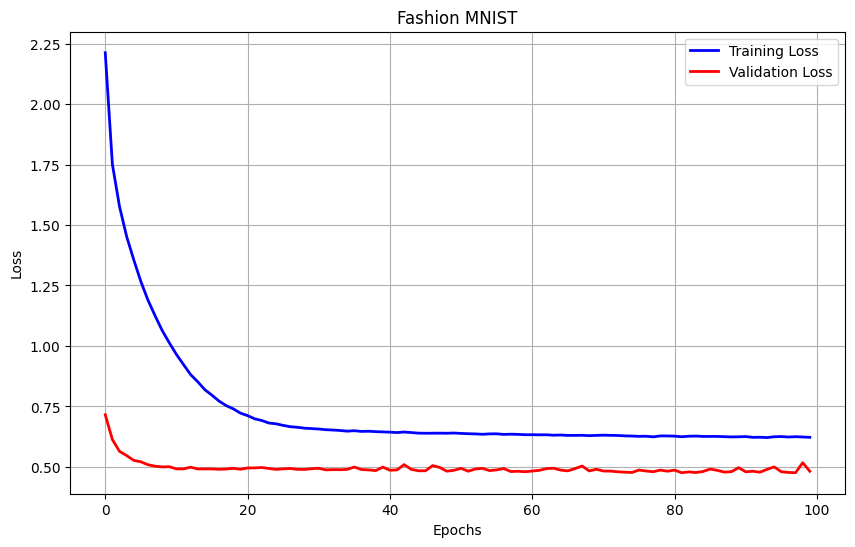

In [ ]:
# Plot training curves
plot_losses(train_losses, val_losses)

In [ ]:
# Evaluate on test set
test_model(model)

TEST ACCURACY: 0.8318 (83.18%)


0.8318

---
## Section 10: Hyperparameter Tuning - Grid Search

### CONCEPT: Grid Search

Grid Search systematically tries **ALL combinations** of hyperparameters. It is exponentially expensive (3 × 3 × 3 × 2 = 54 combinations). If each training takes 2 minutes, 54 combos = 108 minutes :(((

In [ ]:
# Hyperparameter search space for experimentation. You can reduce the options for quicker runs.
param_grid = {
    'lr': [0.0001, 0.001],       # Learning rates
    'dropout_rate': [0.3, 0.5, 0.7],         # Dropout rates
    'l1_lambda': [0.0, 0.001],               # L1 regularization
    'l2_lambda': [0.0, 0.001],               # L2 regularization
    'weight_init': ['xavier', 'kaiming']     # Initialization methods
}

In [ ]:
import itertools

def grid_search(param_grid):
    """
    Perform grid search over hyperparameter space.

    Args:
        param_grid: Dictionary of hyperparameter lists to search

    Returns:
        best_model: Model with best validation loss
        best_params: Dictionary of best hyperparameters
    """
    best_val_loss = float('inf')
    best_params = None
    best_model = None

    # -------------------------------------------------------------------------
    # TODO 13: Generate all hyperparameter combinations
    # -------------------------------------------------------------------------
    # HINT:
    #   keys = list(param_grid.keys())
    #   combinations = use itertools.product to get all combos
    #
    #   Then iterate: for combo in combinations:
    #       params = dict(zip(keys, combo))
    # -------------------------------------------------------------------------

    keys = list(param_grid.keys())
    values = param_grid.values()
    combinations = list(itertools.product(*values))

    # -------------------------------------------------------------------------


    print(f"Grid Search: Testing {len(combinations)} combinations\n")

    for i, combo in enumerate(combinations):
        params = dict(zip(keys, combo))

        print(f"[{i+1}/{len(combinations)}] Testing: {params}")

        # ---------------------------------------------------------------------
        # TODO 14: Train model with current params and track best
        # ---------------------------------------------------------------------

        current_model, train_losses, val_losses = train_model(**params)

        current_min_val_loss = min(val_losses)

        if current_min_val_loss < best_val_loss:
            best_val_loss = current_min_val_loss
            best_params = params
            best_model = current_model
        # ---------------------------------------------------------------------


    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Parameters: {best_params}")

    return best_model, best_params

In [ ]:
# WARNING: This might take a long time! Only run if you have time to spare.
# Uncomment to run grid search:

# best_model_grid, best_params_grid = grid_search(param_grid)
# print("Testing best model from Grid Search:")
# test_model(best_model_grid)

---
## Section 11: Hyperparameter Tuning - Random Search

### CONCEPT: Random Search

Random Search samples **random combinations** from the hyperparameter space.


In [ ]:
def random_search(param_grid, n_iterations=10):
    """
    Perform random search over hyperparameter space.
    It will look like grid search but you will sample random combinations.

    Args:
        param_grid: Dictionary of hyperparameter lists to sample from
        n_iterations: Number of random combinations to try

    Returns:
        best_model: Model with best validation loss
        best_params: Dictionary of best hyperparameters
    """
    # -------------------------------------------------------------------------
    # TODO 15: Implement random search
    # -------------------------------------------------------------------------

    best_val_loss = float('inf')
    best_params = None
    best_model = None

    keys = list(param_grid.keys())

    print(f"Random Search: Testing {n_iterations} random combinations\n")

    for i in range(n_iterations):
        params = {k: random.choice(param_grid[k]) for k in keys}

        print(f"[{i+1}/{n_iterations}] Testing: {params}")

        model, train_losses, val_losses = train_model(**params)
        current_min_val_loss = min(val_losses)

        if current_min_val_loss < best_val_loss:
            best_val_loss = current_min_val_loss
            best_params = params
            best_model = model

    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Parameters: {best_params}")

    return best_model, best_params

In [ ]:
best_model_random, best_params_random = random_search(param_grid, n_iterations=10)
print("\nTesting best model from Random Search:")
test_model(best_model_random)

Random Search: Testing 10 random combinations

[1/10] Testing: {'lr': 0.0001, 'dropout_rate': 0.3, 'l1_lambda': 0.001, 'l2_lambda': 0.0, 'weight_init': 'xavier'}
Weights initialized using xavier method
TRAINING STARTED
Epoch [ 1/100] | Train Loss: 12.1658 | Val Loss: 2.2072
Checkpoint saved! (val_loss: 2.2072)
Epoch [ 2/100] | Train Loss: 12.0210 | Val Loss: 2.0994
Checkpoint saved! (val_loss: 2.0994)
Epoch [ 3/100] | Train Loss: 11.9164 | Val Loss: 2.0093
Checkpoint saved! (val_loss: 2.0093)
Epoch [ 4/100] | Train Loss: 11.8156 | Val Loss: 1.9272
Checkpoint saved! (val_loss: 1.9272)
Epoch [ 5/100] | Train Loss: 11.7248 | Val Loss: 1.8508
Checkpoint saved! (val_loss: 1.8508)
Epoch [ 6/100] | Train Loss: 11.6402 | Val Loss: 1.7792
Checkpoint saved! (val_loss: 1.7792)
Epoch [ 7/100] | Train Loss: 11.5628 | Val Loss: 1.7128
Checkpoint saved! (val_loss: 1.7128)
Epoch [ 8/100] | Train Loss: 11.4866 | Val Loss: 1.6511
Checkpoint saved! (val_loss: 1.6511)
Epoch [ 9/100] | Train Loss: 11.4163 